<a href="https://colab.research.google.com/github/OsirisEscaL/Parkinson_Project/blob/main/LogisticRegression_Parkinson_HeredetaryAtaxias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, balanced_accuracy_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif, SequentialFeatureSelector, SelectFromModel, RFE
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE
from sklearn.model_selection import GridSearchCV

In [2]:
ds = pd.read_csv('Parkinson_HeredetaryAtaxias.csv') # Cambiar dataset
ds = ds.drop(['Unnamed: 0'], axis=1)
X = ds.iloc[:, 0:-1].values
y = ds.iloc[:, -1].values

rng = np.random.default_rng(seed=42)
random = rng.integers(10000, size=50)

scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

In [3]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000, random_state = 42)

In [4]:
results = {}

modelaccuracy = []
modelprecision = []
modelsensitivity = []
modelspecificity = []
modelbalanced_accuracy = []
modelf1 = []
modelroc_auc = []

for rand in random:
    skfaccuracy = []
    skfprecision = []
    skfsensitivity = []
    skfspecificity = []
    skfbalanced_accuracy = []
    skff1 = []
    skfroc_auc = []
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand)
    for train_index, test_index in stratified_kfold.split(scaled_X, y):
        X_train, X_test = scaled_X[train_index], scaled_X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=1)
        sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
        specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        skfaccuracy.append(accuracy)
        skfprecision.append(precision)
        skfsensitivity.append(sensitivity)
        skfspecificity.append(specificity)
        skfbalanced_accuracy.append(balanced_accuracy)
        skff1.append(f1)
        skfroc_auc.append(roc_auc)
    modelaccuracy.append(np.mean(skfaccuracy))
    modelprecision.append(np.mean(skfprecision))
    modelsensitivity.append(np.mean(skfsensitivity))
    modelspecificity.append(np.mean(skfspecificity))
    modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
    modelf1.append(np.mean(skff1))
    modelroc_auc.append(np.mean(skfroc_auc))
mean_accuracy = np.mean(modelaccuracy)
mean_precision = np.mean(modelprecision)
mean_sensitivity = np.mean(modelsensitivity)
mean_specificity = np.mean(modelspecificity)
mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
mean_f1 = np.mean(modelf1)
mean_roc_auc = np.mean(modelroc_auc)
std_accuracy = np.std(modelaccuracy)
std_precision = np.std(modelprecision)
std_sensitivity = np.std(modelsensitivity)
std_specificity = np.std(modelspecificity)
std_balanced_accuracy = np.std(modelbalanced_accuracy)
std_f1 = np.std(modelf1)
std_roc_auc = np.std(modelroc_auc)
results['LogisticRegression'] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                                  'Std_Balanced_Accuracy': std_balanced_accuracy,
                                  'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                                  'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                                  'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                                  'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                                  'Mean_F1': mean_f1, 'Std_F1': std_f1,
                                  'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

modelbalanced_accuracy_base = modelbalanced_accuracy
results_ds = pd.DataFrame(results).T
results_ds

,Mean_Accuracy,Mean_Balanced_Accuracy,Mean_F1,Mean_Precision,Mean_ROC_AUC,Mean_Sensitivity,Mean_Specificity,Std_Accuracy,Std_Balanced_Accuracy,Std_F1,Std_Precision,Std_ROC_AUC,Std_Sensitivity,Std_Specificity
SVC,0.693429,0.549758,0.801013,0.783009,0.549758,0.830182,0.269333,0.041128,0.055173,0.02905,0.027163,0.055173,0.041455,0.098396


Oversampling

In [5]:
methods = [
    ("Random Over Sampler", RandomOverSampler(sampling_strategy='auto', random_state=42)),
    ("SMOTE", SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)),
    ("ADASYN", ADASYN(sampling_strategy='auto', random_state=42, n_neighbors=5)),
    ("BorderlineSMOTE", BorderlineSMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5, m_neighbors=10)),
    ("SVMSMOTE", SVMSMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5, m_neighbors=10)),
    ("KMeansSMOTE", KMeansSMOTE(sampling_strategy='auto', random_state=42, k_neighbors=2, cluster_balance_threshold=0.01))
]

In [6]:
results = {}
results_raw = {}

for method_name, method in methods:
    sample_x, sample_y = method.fit_resample(scaled_X, y)
    modelaccuracy = []
    modelprecision = []
    modelsensitivity = []
    modelspecificity = []
    modelbalanced_accuracy = []
    modelf1 = []
    modelroc_auc = []
    for num in random:
        skfaccuracy = []
        skfprecision = []
        skfsensitivity = []
        skfspecificity = []
        skfbalanced_accuracy = []
        skff1 = []
        skfroc_auc = []
        stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=num)
        for train_index, test_index in stratified_kfold.split(sample_x,sample_y):
            X_train, X_test = sample_x[train_index], sample_x[test_index]
            y_train, y_test = sample_y[train_index], sample_y[test_index]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=1)
            sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
            specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
            balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred)
            skfaccuracy.append(accuracy)
            skfprecision.append(precision)
            skfsensitivity.append(sensitivity)
            skfspecificity.append(specificity)
            skfbalanced_accuracy.append(balanced_accuracy)
            skff1.append(f1)
            skfroc_auc.append(roc_auc)
        modelaccuracy.append(np.mean(skfaccuracy))
        modelprecision.append(np.mean(skfprecision))
        modelsensitivity.append(np.mean(skfsensitivity))
        modelspecificity.append(np.mean(skfspecificity))
        modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
        modelf1.append(np.mean(skff1))
        modelroc_auc.append(np.mean(skfroc_auc))
    mean_accuracy = np.mean(modelaccuracy)
    mean_precision = np.mean(modelprecision)
    mean_sensitivity = np.mean(modelsensitivity)
    mean_specificity = np.mean(modelspecificity)
    mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
    mean_f1 = np.mean(modelf1)
    mean_roc_auc = np.mean(modelroc_auc)
    std_accuracy = np.std(modelaccuracy)
    std_precision = np.std(modelprecision)
    std_sensitivity = np.std(modelsensitivity)
    std_specificity = np.std(modelspecificity)
    std_balanced_accuracy = np.std(modelbalanced_accuracy)
    std_f1 = np.std(modelf1)
    std_roc_auc = np.std(modelroc_auc)
    results_raw[method_name] = {'Balanced_Accuracy': modelbalanced_accuracy,
                                'Accuracy': modelaccuracy,
                                'Precision': modelprecision,
                                'Sensitivity': modelsensitivity,
                                'Specificity': modelspecificity,
                                'F1': modelf1,
                                'ROC_AUC': modelroc_auc}
    results[method_name] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                            'Std_Balanced_Accuracy': std_balanced_accuracy,
                            'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                            'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                            'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                            'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                            'Mean_F1': mean_f1, 'Std_F1': std_f1,
                            'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

results_raw_over_ds = pd.DataFrame(results_raw)
results_raw_over_ds.to_csv('Results_Raw_Oversampling_LogisticRegression.csv')

results_over_ds = pd.DataFrame(results).T
results_over_ds.to_csv('Results_Oversampling_LogisticRegression.csv')
results_over_ds

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Mean_Balanced_Accuracy,Std_Balanced_Accuracy,Mean_Accuracy,Std_Accuracy,Mean_Precision,Std_Precision,Mean_Sensitivity,Std_Sensitivity,Mean_Specificity,Std_Specificity,Mean_F1,Std_F1,Mean_ROC_AUC,Std_ROC_AUC
Random Over Sampler,0.850400,0.025993,0.850390,0.025865,0.945398,0.040479,0.751818,0.033566,0.948982,0.040966,0.828549,0.027566,0.850400,0.025993
SMOTE,0.834255,0.024057,0.834459,0.023879,0.900762,0.030211,0.762873,0.039927,0.905636,0.030548,0.817382,0.028661,0.834255,0.024057
ADASYN,0.853009,0.025177,0.856909,0.025049,0.951484,0.035176,0.747382,0.039133,0.958636,0.031126,0.829447,0.030013,0.853009,0.025177
BorderlineSMOTE,0.841891,0.029411,0.841931,0.029026,0.934005,0.037437,0.744800,0.037329,0.938982,0.035284,0.819774,0.033640,0.841891,0.029411
SVMSMOTE,0.815581,0.027682,0.806000,0.027416,0.901636,0.029817,0.763091,0.036703,0.868071,0.040591,0.817844,0.027467,0.815581,0.027682
KMeansSMOTE,0.837927,0.018099,0.838450,0.017829,0.900854,0.019955,0.763709,0.032115,0.912145,0.019346,0.819085,0.022677,0.837927,0.018099


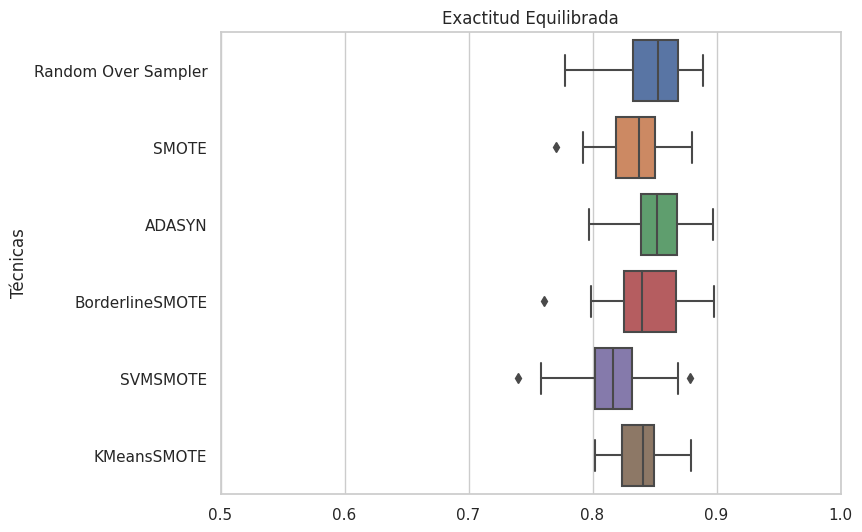

In [7]:
balanced_accuracy = pd.DataFrame(results_raw_over_ds.loc['Balanced_Accuracy'])
modelos = balanced_accuracy.index

plt.figure(figsize=(8, 6))
sns.set_theme(style="whitegrid")
sns.boxplot(data=balanced_accuracy['Balanced_Accuracy'], orient='h')
plt.title('Exactitud Equilibrada')
plt.xlim(0.5, 1)
plt.ylabel('Técnicas')
plt.gca().set_yticklabels(modelos)
plt.savefig('Boxplot_Oversampling_LogisticRegression.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
samplers = ['Random Over Sampler', 'SMOTE', 'ADASYN', 'BorderlineSMOTE',
            'SVMSMOTE', 'KMeansSMOTE']

comparison = {}
alpha = 0.05
for sample1 in samplers:
  val1 = results_raw_over_ds.loc['Balanced_Accuracy', sample1]
  for sample2 in samplers:
    val2 = results_raw_over_ds.loc['Balanced_Accuracy', sample2]
    statistic, p_value = stats.mannwhitneyu(val1, val2, alternative='two-sided')
    if p_value < alpha:
      statistic, p_value = stats.mannwhitneyu(val1, val2, alternative='greater')
      if p_value < alpha:
        greater = 'La primera muestra es significativamente mayor que la segunda.'
        comparison[sample1, sample2] = {'statistic': statistic,
                                        'p_value': p_value,
                                        'greater': greater}
    else:
      greater = 'No hay evidencia suficiente para afirmar que las muestras tienen distribuciones diferentes.'
      comparison[sample1, sample2] = {'statistic': statistic,
                                        'p_value': p_value,
                                        'greater': greater}

comparison = pd.DataFrame(comparison).T
comparison.to_csv('MannWhitneyU_Oversampling_LogisticRegression.csv')
comparison

statistic   p_value  \
Random Over Sampler Random Over Sampler    1250.0       1.0   
                    SMOTE                  1705.5  0.000852   
                    ADASYN                 1212.5  0.798643   
                    BorderlineSMOTE        1477.5  0.117552   
                    SVMSMOTE               2053.0       0.0   
                    KMeansSMOTE            1659.0  0.002425   
SMOTE               SMOTE                  1250.0       1.0   
                    BorderlineSMOTE        1079.5  0.241141   
                    SVMSMOTE               1735.0  0.000419   
                    KMeansSMOTE            1138.0  0.441925   
ADASYN              Random Over Sampler    1287.5  0.798643   
                    SMOTE                  1748.5  0.000298   
                    ADASYN                 1250.0       1.0   
                    BorderlineSMOTE        1548.5  0.019962   
                    SVMSMOTE               2109.0       0.0   
                    KMeansSMOTE            1730.0  0.000473   
BorderlineSMOTE     Random Over Sampler    1022.5  0.117552   
                    SMOTE                  1420.5  0.241141   
                    BorderlineSMOTE        1250.0       1.0   
                    SVMSMOTE               1850.0  0.000018   
                    KMeansSMOTE            1340.0  0.537142   
SVMSMOTE            SVMSMOTE               1250.0       1.0   
KMeansSMOTE         SMOTE                  1362.0  0.441925   
                    BorderlineSMOTE        1160.0  0.537142   
                    SVMSMOTE               1874.0  0.000009   
                    KMeansSMOTE            1250.0       1.0   

                                                                                   greater  
Random Over Sampler Random Over Sampler  No hay evidencia suficiente para afirmar que l...  
                    SMOTE                La primera muestra es significativamente mayor...  
                    ADASYN               No hay evidencia suficiente para afirmar que l...  
                    BorderlineSMOTE      No hay evidencia suficiente para afirmar que l...  
                    SVMSMOTE             La primera muestra es significativamente mayor...  
                    KMeansSMOTE          La primera muestra es significativamente mayor...  
SMOTE               SMOTE                No hay evidencia suficiente para afirmar que l...  
                    BorderlineSMOTE      No hay evidencia suficiente para afirmar que l...  
                    SVMSMOTE             La primera muestra es significativamente mayor...  
                    KMeansSMOTE          No hay evidencia suficiente para afirmar que l...  
ADASYN              Random Over Sampler  No hay evidencia suficiente para afirmar que l...  
                    SMOTE                La primera muestra es significativamente mayor...  
                    ADASYN               No hay evidencia suficiente para afirmar que l...  
                    BorderlineSMOTE      La primera muestra es significativamente mayor...  
                    SVMSMOTE             La primera muestra es significativamente mayor...  
                    KMeansSMOTE          La primera muestra es significativamente mayor...  
BorderlineSMOTE     Random Over Sampler  No hay evidencia suficiente para afirmar que l...  
                    SMOTE                No hay evidencia suficiente para afirmar que l...  
                    BorderlineSMOTE      No hay evidencia suficiente para afirmar que l...  
                    SVMSMOTE             La primera muestra es significativamente mayor...  
                    KMeansSMOTE          No hay evidencia suficiente para afirmar que l...  
SVMSMOTE            SVMSMOTE             No hay evidencia suficiente para afirmar que l...  
KMeansSMOTE         SMOTE                No hay evidencia suficiente para afirmar que l...  
                    BorderlineSMOTE      No hay evidencia suficiente para afirmar que l...  
             

In [9]:
oversampler = ADASYN(sampling_strategy='auto', random_state=42, n_neighbors=5) # Cambiar dependiendo cual fue mejor
oversample_X, oversample_y = oversampler.fit_resample(scaled_X, y)

In [10]:
results = {}

modelaccuracy = []
modelprecision = []
modelsensitivity = []
modelspecificity = []
modelbalanced_accuracy = []
modelf1 = []
modelroc_auc = []

for rand in random:
    skfaccuracy = []
    skfprecision = []
    skfsensitivity = []
    skfspecificity = []
    skfbalanced_accuracy = []
    skff1 = []
    skfroc_auc = []
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand)
    for train_index, test_index in stratified_kfold.split(oversample_X,oversample_y):
        X_train, X_test = oversample_X[train_index], oversample_X[test_index]
        y_train, y_test = oversample_y[train_index], oversample_y[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=1)
        sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
        specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        skfaccuracy.append(accuracy)
        skfprecision.append(precision)
        skfsensitivity.append(sensitivity)
        skfspecificity.append(specificity)
        skfbalanced_accuracy.append(balanced_accuracy)
        skff1.append(f1)
        skfroc_auc.append(roc_auc)
    modelaccuracy.append(np.mean(skfaccuracy))
    modelprecision.append(np.mean(skfprecision))
    modelsensitivity.append(np.mean(skfsensitivity))
    modelspecificity.append(np.mean(skfspecificity))
    modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
    modelf1.append(np.mean(skff1))
    modelroc_auc.append(np.mean(skfroc_auc))
mean_accuracy = np.mean(modelaccuracy)
mean_precision = np.mean(modelprecision)
mean_sensitivity = np.mean(modelsensitivity)
mean_specificity = np.mean(modelspecificity)
mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
mean_f1 = np.mean(modelf1)
mean_roc_auc = np.mean(modelroc_auc)
std_accuracy = np.std(modelaccuracy)
std_precision = np.std(modelprecision)
std_sensitivity = np.std(modelsensitivity)
std_specificity = np.std(modelspecificity)
std_balanced_accuracy = np.std(modelbalanced_accuracy)
std_f1 = np.std(modelf1)
std_roc_auc = np.std(modelroc_auc)
results['LogisticRegression'] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                                  'Std_Balanced_Accuracy': std_balanced_accuracy,
                                  'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                                  'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                                  'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                                  'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                                  'Mean_F1': mean_f1, 'Std_F1': std_f1,
                                  'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

modelbalanced_accuracy_over = modelbalanced_accuracy
results_ds = pd.DataFrame(results).T
results_ds

,Mean_Accuracy,Mean_Balanced_Accuracy,Mean_F1,Mean_Precision,Mean_ROC_AUC,Mean_Sensitivity,Mean_Specificity,Std_Accuracy,Std_Balanced_Accuracy,Std_F1,Std_Precision,Std_ROC_AUC,Std_Sensitivity,Std_Specificity
SVC,0.856909,0.853009,0.829447,0.951484,0.853009,0.747382,0.958636,0.025049,0.025177,0.030013,0.035176,0.025177,0.039133,0.031126


In [11]:
statistic, p_value = stats.mannwhitneyu(modelbalanced_accuracy_over, modelbalanced_accuracy_base, alternative='two-sided')
if p_value < alpha:
    statistic, p_value = stats.mannwhitneyu(modelbalanced_accuracy_over, modelbalanced_accuracy_base, alternative='greater')
    if p_value < alpha:
        greater = 'La primera muestra es significativamente mayor que la segunda.'
else:
      greater = 'No hay evidencia suficiente para afirmar que las muestras tienen distribuciones diferentes.'
print(greater)

La primera muestra es significativamente mayor que la segunda.


Feature Selection

In [12]:
ds_X = ds.iloc[:, 0:-1]
features = ds_X.shape[1]

In [13]:
# SelectKBest
results = {}
results_raw = {}

for num in range(1, features):
    selector = SelectKBest(score_func=f_classif, k=num)
    new_X = selector.fit_transform(oversample_X, oversample_y)
    modelaccuracy = []
    modelprecision = []
    modelsensitivity = []
    modelspecificity = []
    modelbalanced_accuracy = []
    modelf1 = []
    modelroc_auc = []
    for rand in random:
        skfaccuracy = []
        skfprecision = []
        skfsensitivity = []
        skfspecificity = []
        skfbalanced_accuracy = []
        skff1 = []
        skfroc_auc = []
        stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand)
        for train_index, test_index in stratified_kfold.split(new_X,oversample_y):
            X_train, X_test = new_X[train_index], new_X[test_index]
            y_train, y_test = oversample_y[train_index], oversample_y[test_index]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=1)
            sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
            specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
            balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred)
            skfaccuracy.append(accuracy)
            skfprecision.append(precision)
            skfsensitivity.append(sensitivity)
            skfspecificity.append(specificity)
            skfbalanced_accuracy.append(balanced_accuracy)
            skff1.append(f1)
            skfroc_auc.append(roc_auc)
        modelaccuracy.append(np.mean(skfaccuracy))
        modelprecision.append(np.mean(skfprecision))
        modelsensitivity.append(np.mean(skfsensitivity))
        modelspecificity.append(np.mean(skfspecificity))
        modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
        modelf1.append(np.mean(skff1))
        modelroc_auc.append(np.mean(skfroc_auc))
    mean_accuracy = np.mean(modelaccuracy)
    mean_precision = np.mean(modelprecision)
    mean_sensitivity = np.mean(modelsensitivity)
    mean_specificity = np.mean(modelspecificity)
    mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
    mean_f1 = np.mean(modelf1)
    mean_roc_auc = np.mean(modelroc_auc)
    std_accuracy = np.std(modelaccuracy)
    std_precision = np.std(modelprecision)
    std_sensitivity = np.std(modelsensitivity)
    std_specificity = np.std(modelspecificity)
    std_balanced_accuracy = np.std(modelbalanced_accuracy)
    std_f1 = np.std(modelf1)
    std_roc_auc = np.std(modelroc_auc)
    results_raw[num-1] = {'Balanced_Accuracy': modelbalanced_accuracy,
                                'Accuracy': modelaccuracy,
                                'Precision': modelprecision,
                                'Sensitivity': modelsensitivity,
                                'Specificity': modelspecificity,
                                'F1': modelf1,
                                'ROC_AUC': modelroc_auc}
    results[num-1] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                            'Std_Balanced_Accuracy': std_balanced_accuracy,
                            'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                            'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                            'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                            'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                            'Mean_F1': mean_f1, 'Std_F1': std_f1,
                            'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

results_raw_selectK_ds = pd.DataFrame(results_raw)
results_raw_selectK_ds.to_csv('Results_Raw_SelectKBest_LogisticRegression.csv')

results_selectK_ds = pd.DataFrame(results).T
number_of_features = results_selectK_ds.index + 1
results_selectK_ds.insert(0, 'Number_Features', number_of_features)
results_selectK_ds = results_selectK_ds.sort_values(by='Mean_Balanced_Accuracy', ascending=False)
results_selectK_ds.to_csv('Results_SelectKBest_LogisticRegression.csv')
results_selectK_ds.head(5)

,Number_Features,Mean_Balanced_Accuracy,Std_Balanced_Accuracy,Mean_Accuracy,Std_Accuracy,Mean_Precision,Std_Precision,Mean_Sensitivity,Std_Sensitivity,Mean_Specificity,Std_Specificity,Mean_F1,Std_F1,Mean_ROC_AUC,Std_ROC_AUC
47,48,0.869148,0.024308,0.872545,0.024154,0.954970,0.034904,0.778691,0.036605,0.959606,0.031335,0.850440,0.029009,0.869148,0.024308
50,51,0.869130,0.024326,0.872545,0.024291,0.955874,0.035579,0.777200,0.035646,0.961061,0.031274,0.849759,0.028230,0.869130,0.024326
48,49,0.866912,0.025664,0.870364,0.025442,0.954792,0.034695,0.773855,0.038086,0.959970,0.030721,0.847567,0.030321,0.866912,0.025664
49,50,0.866512,0.024082,0.870000,0.024001,0.956027,0.035419,0.771964,0.036367,0.961061,0.031591,0.846998,0.028339,0.866512,0.024082
51,52,0.860236,0.022971,0.864000,0.022851,0.954150,0.033450,0.760473,0.039039,0.960000,0.029759,0.838118,0.028180,0.860236,0.022971


In [14]:
best_number_K = 48 # Cambiar por el mejor numero de caracteristicas encontradas anteriormente

selector_K = SelectKBest(score_func=f_classif, k=best_number_K)
new_X_K = selector_K.fit_transform(oversample_X, oversample_y)
selected_feature_indices = selector_K.get_support()
selected_feature_names = ds_X.columns[selected_feature_indices]

print("Características seleccionadas usando SelectKBest:")
print(selected_feature_names)

Características seleccionadas usando SelectKBest:
Index(['Cadence_Der', 'Mean_step_lenght_Der', 'Velocity_Der', 'RMS_VER_Der',
       'RMS_ML_Der', 'RMS_AP_Der', 'IPSD_VER_Der', 'Freq_50_VER_Der',
       'Freq_75_VER_Der', 'Freq_50_ML_Der', 'Freq_90_ML_Der',
       'Freq_100_ML_Der', 'IPSD_AP_Der', 'Freq_50_AP_Der', 'Freq_75_AP_Der',
       'Freq_90_AP_Der', 'Freq_100_AP_Der', 'Sym_VER_Der', 'Sym_AP_Der',
       'Stride_Reg_ML_Der', 'Stride_Reg_AP_Der', 'Step_Reg_VER_Der',
       'Step_Reg_AP_Der', 'Cadence_Izq', 'Mean_step_lenght_Izq',
       'Velocity_Izq', 'RMS_VER_Izq', 'RMS_ML_Izq', 'RMS_AP_Izq',
       'Freq_50_VER_Izq', 'Freq_75_VER_Izq', 'Freq_90_VER_Izq',
       'Freq_100_VER_Izq', 'IPSD_ML_Izq', 'Freq_75_ML_Izq', 'Freq_90_ML_Izq',
       'Freq_100_ML_Izq', 'IPSD_AP_Izq', 'Freq_50_AP_Izq', 'Freq_75_AP_Izq',
       'Freq_90_AP_Izq', 'Freq_100_AP_Izq', 'Sym_VER_Izq', 'Sym_AP_Izq',
       'Stride_Reg_VER_Izq', 'Stride_Reg_AP_Izq', 'Step_Reg_VER_Izq',
       'Step_Reg_AP_Izq'],
  

In [15]:
# Sequential Feature Selector
results = {}
results_raw = {}

for num in range(1, features):
    selector = SequentialFeatureSelector(model, n_features_to_select=num, direction='forward', cv=5, scoring='balanced_accuracy')
    new_X = selector.fit_transform(oversample_X, oversample_y)
    modelaccuracy = []
    modelprecision = []
    modelsensitivity = []
    modelspecificity = []
    modelbalanced_accuracy = []
    modelf1 = []
    modelroc_auc = []
    for rand in random:
        skfaccuracy = []
        skfprecision = []
        skfsensitivity = []
        skfspecificity = []
        skfbalanced_accuracy = []
        skff1 = []
        skfroc_auc = []
        stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand)
        for train_index, test_index in stratified_kfold.split(new_X,oversample_y):
            X_train, X_test = new_X[train_index], new_X[test_index]
            y_train, y_test = oversample_y[train_index], oversample_y[test_index]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=1)
            sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
            specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
            balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred)
            skfaccuracy.append(accuracy)
            skfprecision.append(precision)
            skfsensitivity.append(sensitivity)
            skfspecificity.append(specificity)
            skfbalanced_accuracy.append(balanced_accuracy)
            skff1.append(f1)
            skfroc_auc.append(roc_auc)
        modelaccuracy.append(np.mean(skfaccuracy))
        modelprecision.append(np.mean(skfprecision))
        modelsensitivity.append(np.mean(skfsensitivity))
        modelspecificity.append(np.mean(skfspecificity))
        modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
        modelf1.append(np.mean(skff1))
        modelroc_auc.append(np.mean(skfroc_auc))
    mean_accuracy = np.mean(modelaccuracy)
    mean_precision = np.mean(modelprecision)
    mean_sensitivity = np.mean(modelsensitivity)
    mean_specificity = np.mean(modelspecificity)
    mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
    mean_f1 = np.mean(modelf1)
    mean_roc_auc = np.mean(modelroc_auc)
    std_accuracy = np.std(modelaccuracy)
    std_precision = np.std(modelprecision)
    std_sensitivity = np.std(modelsensitivity)
    std_specificity = np.std(modelspecificity)
    std_balanced_accuracy = np.std(modelbalanced_accuracy)
    std_f1 = np.std(modelf1)
    std_roc_auc = np.std(modelroc_auc)
    results_raw[num-1] = {'Balanced_Accuracy': modelbalanced_accuracy,
                                'Accuracy': modelaccuracy,
                                'Precision': modelprecision,
                                'Sensitivity': modelsensitivity,
                                'Specificity': modelspecificity,
                                'F1': modelf1,
                                'ROC_AUC': modelroc_auc}
    results[num-1] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                            'Std_Balanced_Accuracy': std_balanced_accuracy,
                            'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                            'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                            'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                            'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                            'Mean_F1': mean_f1, 'Std_F1': std_f1,
                            'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

results_raw_sequential_ds = pd.DataFrame(results_raw)
results_raw_sequential_ds.to_csv('Results_Raw_Sequential_LogisticRegression.csv')

results_sequential_ds = pd.DataFrame(results).T
number_of_features = results_sequential_ds.index + 1
results_sequential_ds.insert(0, 'Number_Features', number_of_features)
results_sequential_ds = results_sequential_ds.sort_values(by='Mean_Balanced_Accuracy', ascending=False)
results_sequential_ds.to_csv('Results_Sequential_LogisticRegression.csv')
results_sequential_ds.head(5)

,Number_Features,Mean_Balanced_Accuracy,Std_Balanced_Accuracy,Mean_Accuracy,Std_Accuracy,Mean_Precision,Std_Precision,Mean_Sensitivity,Std_Sensitivity,Mean_Specificity,Std_Specificity,Mean_F1,Std_F1,Mean_ROC_AUC,Std_ROC_AUC
18,19,0.883333,0.021471,0.885091,0.021185,0.927880,0.028668,0.834364,0.029316,0.932303,0.030289,0.872197,0.024301,0.883333,0.021471
21,22,0.883176,0.023911,0.885091,0.023898,0.929861,0.031648,0.834109,0.030880,0.932242,0.031621,0.872368,0.026715,0.883176,0.023911
22,23,0.882652,0.027327,0.884545,0.027409,0.931728,0.036302,0.831273,0.032074,0.934030,0.036831,0.871651,0.029919,0.882652,0.027327
20,21,0.882255,0.023349,0.884000,0.023324,0.928278,0.029814,0.832509,0.030663,0.932000,0.030966,0.870872,0.025860,0.882255,0.023349
19,20,0.882021,0.020781,0.883818,0.020513,0.928306,0.028917,0.831709,0.027998,0.932333,0.031374,0.870511,0.022894,0.882021,0.020781


In [16]:
best_number_Q = 19 # Cambiar por el mejor numero de caracteristicas encontradas anteriormente

selector_Q = SequentialFeatureSelector(model, n_features_to_select=best_number_Q, direction='forward', cv=5, scoring='balanced_accuracy')
new_X_Q = selector_Q.fit_transform(oversample_X, oversample_y)
selected_feature_indices = selector_Q.get_support()
selected_feature_names = ds_X.columns[selected_feature_indices]

print("Características seleccionadas usando SequentialFeatureSelector:")
print(selected_feature_names)

Características seleccionadas usando SequentialFeatureSelector:
Index(['Mean_step_lenght_Der', 'Velocity_Der', 'RMS_AP_Der', 'IPSD_VER_Der',
       'Freq_100_VER_Der', 'Freq_75_ML_Der', 'Freq_50_AP_Der',
       'Freq_75_AP_Der', 'Freq_100_AP_Der', 'Mean_step_lenght_Izq',
       'RMS_ML_Izq', 'RMS_AP_Izq', 'Freq_90_VER_Izq', 'IPSD_ML_Izq',
       'IPSD_AP_Izq', 'Freq_50_AP_Izq', 'Freq_90_AP_Izq', 'Freq_100_AP_Izq',
       'Sym_AP_Izq'],
      dtype='object')


In [17]:
# SelectFromModel
results = {}
results_raw = {}

for num in range(1, features):
    selector = SelectFromModel(model, max_features=num)
    new_X = selector.fit_transform(oversample_X, oversample_y)
    modelaccuracy = []
    modelprecision = []
    modelsensitivity = []
    modelspecificity = []
    modelbalanced_accuracy = []
    modelf1 = []
    modelroc_auc = []
    for rand in random:
        skfaccuracy = []
        skfprecision = []
        skfsensitivity = []
        skfspecificity = []
        skfbalanced_accuracy = []
        skff1 = []
        skfroc_auc = []
        stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand)
        for train_index, test_index in stratified_kfold.split(new_X,oversample_y):
            X_train, X_test = new_X[train_index], new_X[test_index]
            y_train, y_test = oversample_y[train_index], oversample_y[test_index]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=1)
            sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
            specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
            balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred)
            skfaccuracy.append(accuracy)
            skfprecision.append(precision)
            skfsensitivity.append(sensitivity)
            skfspecificity.append(specificity)
            skfbalanced_accuracy.append(balanced_accuracy)
            skff1.append(f1)
            skfroc_auc.append(roc_auc)
        modelaccuracy.append(np.mean(skfaccuracy))
        modelprecision.append(np.mean(skfprecision))
        modelsensitivity.append(np.mean(skfsensitivity))
        modelspecificity.append(np.mean(skfspecificity))
        modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
        modelf1.append(np.mean(skff1))
        modelroc_auc.append(np.mean(skfroc_auc))
    mean_accuracy = np.mean(modelaccuracy)
    mean_precision = np.mean(modelprecision)
    mean_sensitivity = np.mean(modelsensitivity)
    mean_specificity = np.mean(modelspecificity)
    mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
    mean_f1 = np.mean(modelf1)
    mean_roc_auc = np.mean(modelroc_auc)
    std_accuracy = np.std(modelaccuracy)
    std_precision = np.std(modelprecision)
    std_sensitivity = np.std(modelsensitivity)
    std_specificity = np.std(modelspecificity)
    std_balanced_accuracy = np.std(modelbalanced_accuracy)
    std_f1 = np.std(modelf1)
    std_roc_auc = np.std(modelroc_auc)
    results_raw[num-1] = {'Balanced_Accuracy': modelbalanced_accuracy,
                                'Accuracy': modelaccuracy,
                                'Precision': modelprecision,
                                'Sensitivity': modelsensitivity,
                                'Specificity': modelspecificity,
                                'F1': modelf1,
                                'ROC_AUC': modelroc_auc}
    results[num-1] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                            'Std_Balanced_Accuracy': std_balanced_accuracy,
                            'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                            'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                            'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                            'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                            'Mean_F1': mean_f1, 'Std_F1': std_f1,
                            'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

results_raw_select_ds = pd.DataFrame(results_raw)
results_raw_select_ds.to_csv('Results_Raw_SelectM_LogisticRegression.csv')

results_select_ds = pd.DataFrame(results).T
number_of_features = results_select_ds.index + 1
results_select_ds.insert(0, 'Number_Features', number_of_features)
results_select_ds = results_select_ds.sort_values(by='Mean_Balanced_Accuracy', ascending=False)
results_select_ds.to_csv('Results_SelectM_LogisticRegression.csv')
results_select_ds.head(5)

,Number_Features,Mean_Balanced_Accuracy,Std_Balanced_Accuracy,Mean_Accuracy,Std_Accuracy,Mean_Precision,Std_Precision,Mean_Sensitivity,Std_Sensitivity,Mean_Specificity,Std_Specificity,Mean_F1,Std_F1,Mean_ROC_AUC,Std_ROC_AUC
15,16,0.919652,0.018397,0.921455,0.018069,0.963251,0.021707,0.874727,0.027137,0.964576,0.021649,0.912549,0.019318,0.919652,0.018397
16,17,0.916018,0.017375,0.918000,0.017200,0.962618,0.021662,0.867855,0.027460,0.964182,0.021431,0.908150,0.018689,0.916018,0.017375
14,15,0.915021,0.017112,0.917091,0.016826,0.963829,0.021969,0.864436,0.023211,0.965606,0.021494,0.907152,0.017948,0.915021,0.017112
18,19,0.910091,0.020778,0.912182,0.020858,0.966239,0.027526,0.851818,0.028772,0.968364,0.025430,0.900959,0.022647,0.910091,0.020778
17,18,0.905985,0.015918,0.908000,0.015813,0.957846,0.022554,0.851455,0.022018,0.960515,0.020063,0.896753,0.017565,0.905985,0.015918


In [18]:
best_number_M = 16 # Cambiar por el mejor numero de caracteristicas encontradas anteriormente

selector_M = SelectFromModel(model, max_features=best_number_M)
new_X_M = selector_M.fit_transform(oversample_X, oversample_y)
selected_feature_indices = selector_M.get_support()
selected_feature_names = ds_X.columns[selected_feature_indices]

print("Características seleccionadas usando SelectFromModel:")
print(selected_feature_names)

Características seleccionadas usando SelectFromModel:
Index(['RMS_AP_Der', 'IPSD_VER_Der', 'Freq_50_ML_Der', 'Freq_75_ML_Der',
       'Freq_100_ML_Der', 'Freq_75_AP_Der', 'Freq_100_AP_Der', 'Sym_AP_Der',
       'Stride_Reg_AP_Der', 'RMS_ML_Izq', 'Freq_90_VER_Izq', 'Freq_100_ML_Izq',
       'Freq_50_AP_Izq', 'Sym_AP_Izq', 'Stride_Reg_AP_Izq', 'Step_Reg_AP_Izq'],
      dtype='object')


In [19]:
# RFE
results = {}
results_raw = {}

for num in range(1, features):
    selector = RFE(model, n_features_to_select=num)
    new_X = selector.fit_transform(oversample_X, oversample_y)
    modelaccuracy = []
    modelprecision = []
    modelsensitivity = []
    modelspecificity = []
    modelbalanced_accuracy = []
    modelf1 = []
    modelroc_auc = []
    for rand in random:
        skfaccuracy = []
        skfprecision = []
        skfsensitivity = []
        skfspecificity = []
        skfbalanced_accuracy = []
        skff1 = []
        skfroc_auc = []
        stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand)
        for train_index, test_index in stratified_kfold.split(new_X,oversample_y):
            X_train, X_test = new_X[train_index], new_X[test_index]
            y_train, y_test = oversample_y[train_index], oversample_y[test_index]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=1)
            sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
            specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
            balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred)
            skfaccuracy.append(accuracy)
            skfprecision.append(precision)
            skfsensitivity.append(sensitivity)
            skfspecificity.append(specificity)
            skfbalanced_accuracy.append(balanced_accuracy)
            skff1.append(f1)
            skfroc_auc.append(roc_auc)
        modelaccuracy.append(np.mean(skfaccuracy))
        modelprecision.append(np.mean(skfprecision))
        modelsensitivity.append(np.mean(skfsensitivity))
        modelspecificity.append(np.mean(skfspecificity))
        modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
        modelf1.append(np.mean(skff1))
        modelroc_auc.append(np.mean(skfroc_auc))
    mean_accuracy = np.mean(modelaccuracy)
    mean_precision = np.mean(modelprecision)
    mean_sensitivity = np.mean(modelsensitivity)
    mean_specificity = np.mean(modelspecificity)
    mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
    mean_f1 = np.mean(modelf1)
    mean_roc_auc = np.mean(modelroc_auc)
    std_accuracy = np.std(modelaccuracy)
    std_precision = np.std(modelprecision)
    std_sensitivity = np.std(modelsensitivity)
    std_specificity = np.std(modelspecificity)
    std_balanced_accuracy = np.std(modelbalanced_accuracy)
    std_f1 = np.std(modelf1)
    std_roc_auc = np.std(modelroc_auc)
    results_raw[num-1] = {'Balanced_Accuracy': modelbalanced_accuracy,
                                'Accuracy': modelaccuracy,
                                'Precision': modelprecision,
                                'Sensitivity': modelsensitivity,
                                'Specificity': modelspecificity,
                                'F1': modelf1,
                                'ROC_AUC': modelroc_auc}
    results[num-1] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                            'Std_Balanced_Accuracy': std_balanced_accuracy,
                            'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                            'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                            'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                            'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                            'Mean_F1': mean_f1, 'Std_F1': std_f1,
                            'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

results_raw_recursive_ds = pd.DataFrame(results_raw)
results_raw_recursive_ds.to_csv('Results_Raw_RFE_LogisticRegression.csv')

results_recursive_ds = pd.DataFrame(results).T
number_of_features = results_recursive_ds.index + 1
results_recursive_ds.insert(0, 'Number_Features', number_of_features)
results_recursive_ds = results_recursive_ds.sort_values(by='Mean_Balanced_Accuracy', ascending=False)
results_recursive_ds.to_csv('Results_RFE_LogisticRegression.csv')
results_recursive_ds.head(5)

,Number_Features,Mean_Balanced_Accuracy,Std_Balanced_Accuracy,Mean_Accuracy,Std_Accuracy,Mean_Precision,Std_Precision,Mean_Sensitivity,Std_Sensitivity,Mean_Specificity,Std_Specificity,Mean_F1,Std_F1,Mean_ROC_AUC,Std_ROC_AUC
10,11,0.926394,0.014635,0.928182,0.014687,0.971440,0.022557,0.880364,0.019700,0.972424,0.021436,0.919769,0.016664,0.926394,0.014635
12,13,0.923794,0.016659,0.925273,0.016890,0.960255,0.022436,0.886073,0.023365,0.961515,0.021097,0.917537,0.018891,0.923794,0.016659
24,25,0.922415,0.018396,0.924364,0.018581,0.972825,0.026901,0.871345,0.022879,0.973485,0.025635,0.915324,0.020391,0.922415,0.018396
25,26,0.921715,0.018410,0.923636,0.018631,0.971819,0.026394,0.870945,0.022417,0.972485,0.025637,0.914615,0.020192,0.921715,0.018410
9,10,0.921591,0.017125,0.923455,0.017257,0.966665,0.023244,0.875818,0.018500,0.967364,0.022937,0.915215,0.018310,0.921591,0.017125


In [20]:
best_number_R = 11 # Cambiar por el mejor numero de caracteristicas encontradas anteriormente

selector_R = SelectFromModel(model, max_features=best_number_R)
new_X_R = selector_R.fit_transform(oversample_X, oversample_y)
selected_feature_indices = selector_R.get_support()
selected_feature_names = ds_X.columns[selected_feature_indices]

print("Características seleccionadas usando SelectFromModel:")
print(selected_feature_names)

Características seleccionadas usando SelectFromModel:
Index(['RMS_AP_Der', 'IPSD_VER_Der', 'Freq_100_ML_Der', 'Freq_75_AP_Der',
       'Freq_100_AP_Der', 'Sym_AP_Der', 'Stride_Reg_AP_Der', 'RMS_ML_Izq',
       'Freq_90_VER_Izq', 'Freq_50_AP_Izq', 'Stride_Reg_AP_Izq'],
      dtype='object')


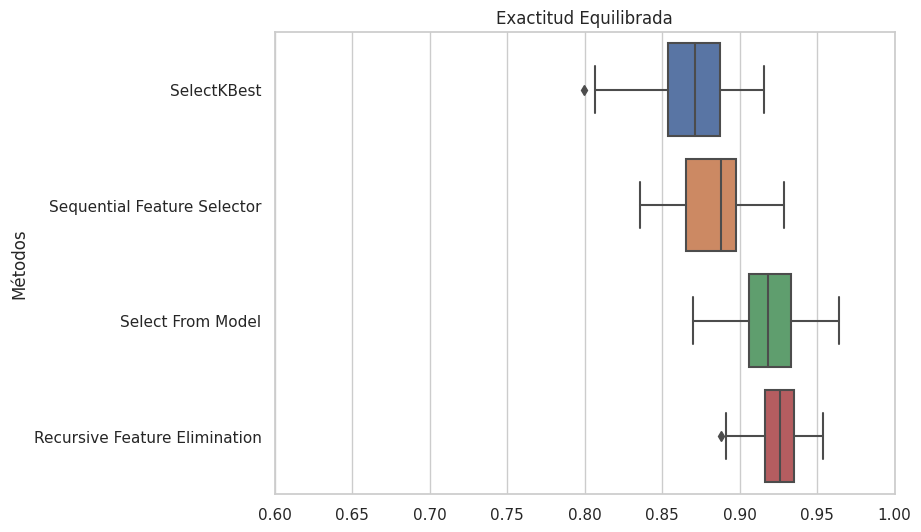

In [21]:
raw_SelectKBest = results_raw_selectK_ds.iloc[0, best_number_K-1]
raw_Sequential = results_raw_sequential_ds.iloc[0, best_number_Q-1]
raw_SelectM = results_raw_select_ds.iloc[0, best_number_M-1]
raw_RFE = results_raw_recursive_ds.iloc[0, best_number_R-1]

raw_SelectKBest = pd.Series(raw_SelectKBest, name='SelectKBest')
raw_Sequential = pd.Series(raw_Sequential, name='Sequential Feature Selector')
raw_SelectM = pd.Series(raw_SelectM, name='Select From Model')
raw_RFE = pd.Series(raw_RFE, name='Recursive Feature Elimination')

FeaturesSelectors = pd.concat([raw_SelectKBest, raw_Sequential,raw_SelectM, raw_RFE], axis=1)

plt.figure(figsize=(8, 6))
sns.set_theme(style="whitegrid")
sns.boxplot(data=FeaturesSelectors, orient='h')
plt.title('Exactitud Equilibrada')
plt.xlim(0.6, 1)
plt.ylabel('Métodos')
plt.savefig('Boxplot_FeatureSelection_LogisticRegression.png', dpi=300, bbox_inches='tight')
plt.show()

In [22]:
samplers = ['SelectKBest', 'Sequential Feature Selector', 'Select From Model',
            'Recursive Feature Elimination']

comparison = {}
alpha = 0.05
for sample1 in samplers:
  val1 = FeaturesSelectors.loc[:, sample1]
  for sample2 in samplers:
    val2 = FeaturesSelectors.loc[:, sample2]
    statistic, p_value = stats.mannwhitneyu(val1, val2, alternative='two-sided')
    if p_value < alpha:
      statistic, p_value = stats.mannwhitneyu(val1, val2, alternative='greater')
      if p_value < alpha:
        greater = 'La primera muestra es significativamente mayor que la segunda.'
        comparison[sample1, sample2] = {'statistic': statistic,
                                        'p_value': p_value,
                                        'greater': greater}
    else:
      greater = 'No hay evidencia suficiente para afirmar que las muestras tienen distribuciones diferentes.'
      comparison[sample1, sample2] = {'statistic': statistic,
                                        'p_value': p_value,
                                        'greater': greater}

comparison = pd.DataFrame(comparison).T
comparison.to_csv('MannWhitneyU_FeaturesSelection_LogisticRegression.csv')
comparison

statistic  \
SelectKBest                   SelectKBest                      1250.0   
Sequential Feature Selector   SelectKBest                      1652.0   
                              Sequential Feature Selector      1250.0   
Select From Model             SelectKBest                      2406.5   
                              Sequential Feature Selector      2252.5   
                              Select From Model                1250.0   
Recursive Feature Elimination SelectKBest                      2464.0   
                              Sequential Feature Selector      2362.0   
                              Select From Model                1555.0   
                              Recursive Feature Elimination    1250.0   

                                                              p_value  \
SelectKBest                   SelectKBest                         1.0   
Sequential Feature Selector   SelectKBest                    0.002819   
                              Sequential Feature Selector         1.0   
Select From Model             SelectKBest                         0.0   
                              Sequential Feature Selector         0.0   
                              Select From Model                   1.0   
Recursive Feature Elimination SelectKBest                         0.0   
                              Sequential Feature Selector         0.0   
                              Select From Model              0.017871   
                              Recursive Feature Elimination       1.0   

                                                                                                       greater  
SelectKBest                   SelectKBest                    No hay evidencia suficiente para afirmar que l...  
Sequential Feature Selector   SelectKBest                    La primera muestra es significativamente mayor...  
                              Sequential Feature Selector    No hay evidencia suficiente para afirmar que l...  
Select From Model             SelectKBest                    La primera muestra es significativamente mayor...  
                              Sequential Feature Selector    La primera muestra es significativamente mayor...  
                              Select From Model              No hay evidencia suficiente para afirmar que l...  
Recursive Feature Elimination SelectKBest                    La primera muestra es significativamente mayor...  
                              Sequential Feature Selector    La primera muestra es significativamente mayor...  
                              Select From Model              La primera muestra es significativamente mayor...  
                              Recursive Feature Elimination  No hay evidencia suficiente para afirmar que l...

In [23]:
best_number = 11 # Cambiar dependiendo cual fue mejor
selector = RFE(model, n_features_to_select = best_number) # Cambiar dependiendo cual fue mejor
new_X = selector.fit_transform(oversample_X, oversample_y)

In [24]:
results = {}

modelaccuracy = []
modelprecision = []
modelsensitivity = []
modelspecificity = []
modelbalanced_accuracy = []
modelf1 = []
modelroc_auc = []

for rand in random:
    skfaccuracy = []
    skfprecision = []
    skfsensitivity = []
    skfspecificity = []
    skfbalanced_accuracy = []
    skff1 = []
    skfroc_auc = []
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand)
    for train_index, test_index in stratified_kfold.split(new_X,oversample_y):
        X_train, X_test = new_X[train_index], new_X[test_index]
        y_train, y_test = oversample_y[train_index], oversample_y[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=1)
        sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
        specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        skfaccuracy.append(accuracy)
        skfprecision.append(precision)
        skfsensitivity.append(sensitivity)
        skfspecificity.append(specificity)
        skfbalanced_accuracy.append(balanced_accuracy)
        skff1.append(f1)
        skfroc_auc.append(roc_auc)
    modelaccuracy.append(np.mean(skfaccuracy))
    modelprecision.append(np.mean(skfprecision))
    modelsensitivity.append(np.mean(skfsensitivity))
    modelspecificity.append(np.mean(skfspecificity))
    modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
    modelf1.append(np.mean(skff1))
    modelroc_auc.append(np.mean(skfroc_auc))
mean_accuracy = np.mean(modelaccuracy)
mean_precision = np.mean(modelprecision)
mean_sensitivity = np.mean(modelsensitivity)
mean_specificity = np.mean(modelspecificity)
mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
mean_f1 = np.mean(modelf1)
mean_roc_auc = np.mean(modelroc_auc)
std_accuracy = np.std(modelaccuracy)
std_precision = np.std(modelprecision)
std_sensitivity = np.std(modelsensitivity)
std_specificity = np.std(modelspecificity)
std_balanced_accuracy = np.std(modelbalanced_accuracy)
std_f1 = np.std(modelf1)
std_roc_auc = np.std(modelroc_auc)
results['LogisticRegression'] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                                  'Std_Balanced_Accuracy': std_balanced_accuracy,
                                  'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                                  'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                                  'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                                  'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                                  'Mean_F1': mean_f1, 'Std_F1': std_f1,
                                  'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

modelbalanced_accuracy_select = modelbalanced_accuracy
results_ds = pd.DataFrame(results).T
results_ds

,Mean_Accuracy,Mean_Balanced_Accuracy,Mean_F1,Mean_Precision,Mean_ROC_AUC,Mean_Sensitivity,Mean_Specificity,Std_Accuracy,Std_Balanced_Accuracy,Std_F1,Std_Precision,Std_ROC_AUC,Std_Sensitivity,Std_Specificity
SVC,0.928182,0.926394,0.919769,0.97144,0.926394,0.880364,0.972424,0.014687,0.014635,0.016664,0.022557,0.014635,0.0197,0.021436


In [25]:
statistic, p_value = stats.mannwhitneyu(modelbalanced_accuracy_select, modelbalanced_accuracy_over, alternative='two-sided')
if p_value < alpha:
    statistic, p_value = stats.mannwhitneyu(modelbalanced_accuracy_select, modelbalanced_accuracy_over, alternative='greater')
    if p_value < alpha:
        greater = 'La primera muestra es significativamente mayor que la segunda.'
else:
      greater = 'No hay evidencia suficiente para afirmar que las muestras tienen distribuciones diferentes.'
print(greater)

La primera muestra es significativamente mayor que la segunda.


Hyperparameter Tunning

In [26]:
parameters = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

grid_search = GridSearchCV(estimator=model, param_grid=parameters, cv=50,  scoring='balanced_accuracy')
grid_search.fit(new_X, oversample_y)

print("Mejores hiperparámetros:", grid_search.best_params_)

Mejores hiperparámetros: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}


In [27]:
model_hyper = LogisticRegression(C= 1, penalty= 'l2', solver= 'liblinear', max_iter=1000, random_state = 42) # Cambiar por los hyperparametros

In [28]:
results = {}

modelaccuracy = []
modelprecision = []
modelsensitivity = []
modelspecificity = []
modelbalanced_accuracy = []
modelf1 = []
modelroc_auc = []

for rand in random:
    skfaccuracy = []
    skfprecision = []
    skfsensitivity = []
    skfspecificity = []
    skfbalanced_accuracy = []
    skff1 = []
    skfroc_auc = []
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand)
    for train_index, test_index in stratified_kfold.split(new_X,oversample_y):
        X_train, X_test = new_X[train_index], new_X[test_index]
        y_train, y_test = oversample_y[train_index], oversample_y[test_index]
        model_hyper.fit(X_train, y_train)
        y_pred = model_hyper.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=1)
        sensitivity = recall_score(y_test, y_pred, average='binary', pos_label=1)
        specificity = recall_score(y_test, y_pred, average='binary', pos_label=0)
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        skfaccuracy.append(accuracy)
        skfprecision.append(precision)
        skfsensitivity.append(sensitivity)
        skfspecificity.append(specificity)
        skfbalanced_accuracy.append(balanced_accuracy)
        skff1.append(f1)
        skfroc_auc.append(roc_auc)
    modelaccuracy.append(np.mean(skfaccuracy))
    modelprecision.append(np.mean(skfprecision))
    modelsensitivity.append(np.mean(skfsensitivity))
    modelspecificity.append(np.mean(skfspecificity))
    modelbalanced_accuracy.append(np.mean(skfbalanced_accuracy))
    modelf1.append(np.mean(skff1))
    modelroc_auc.append(np.mean(skfroc_auc))
mean_accuracy = np.mean(modelaccuracy)
mean_precision = np.mean(modelprecision)
mean_sensitivity = np.mean(modelsensitivity)
mean_specificity = np.mean(modelspecificity)
mean_balanced_accuracy = np.mean(modelbalanced_accuracy)
mean_f1 = np.mean(modelf1)
mean_roc_auc = np.mean(modelroc_auc)
std_accuracy = np.std(modelaccuracy)
std_precision = np.std(modelprecision)
std_sensitivity = np.std(modelsensitivity)
std_specificity = np.std(modelspecificity)
std_balanced_accuracy = np.std(modelbalanced_accuracy)
std_f1 = np.std(modelf1)
std_roc_auc = np.std(modelroc_auc)
results['LogisticRegression'] = {'Mean_Balanced_Accuracy': mean_balanced_accuracy,
                                  'Std_Balanced_Accuracy': std_balanced_accuracy,
                                  'Mean_Accuracy': mean_accuracy, 'Std_Accuracy': std_accuracy,
                                  'Mean_Precision': mean_precision, 'Std_Precision': std_precision,
                                  'Mean_Sensitivity': mean_sensitivity, 'Std_Sensitivity': std_sensitivity,
                                  'Mean_Specificity': mean_specificity, 'Std_Specificity': std_specificity,
                                  'Mean_F1': mean_f1, 'Std_F1': std_f1,
                                  'Mean_ROC_AUC': mean_roc_auc, 'Std_ROC_AUC': std_roc_auc}

modelbalanced_accuracy_hyper = modelbalanced_accuracy
results_ds = pd.DataFrame(results).T
results_ds

,Mean_Accuracy,Mean_Balanced_Accuracy,Mean_F1,Mean_Precision,Mean_ROC_AUC,Mean_Sensitivity,Mean_Specificity,Std_Accuracy,Std_Balanced_Accuracy,Std_F1,Std_Precision,Std_ROC_AUC,Std_Sensitivity,Std_Specificity
SVC,0.926,0.923803,0.915567,0.98084,0.923803,0.865273,0.982333,0.015104,0.015056,0.017216,0.020548,0.015056,0.02295,0.018955


In [29]:
statistic, p_value = stats.mannwhitneyu(modelbalanced_accuracy_hyper, modelbalanced_accuracy_select, alternative='two-sided')
if p_value < alpha:
    statistic, p_value = stats.mannwhitneyu(modelbalanced_accuracy_hyper, modelbalanced_accuracy_select, alternative='greater')
    if p_value < alpha:
        greater = 'La primera muestra es significativamente mayor que la segunda.'
    else:
        greater = 'La primera muestra no es significativamente mayor que la segunda.'
else:
      greater = 'No hay evidencia suficiente para afirmar que las muestras tienen distribuciones diferentes.'
print(greater)

No hay evidencia suficiente para afirmar que las muestras tienen distribuciones diferentes.


Resultados y Curva ROC

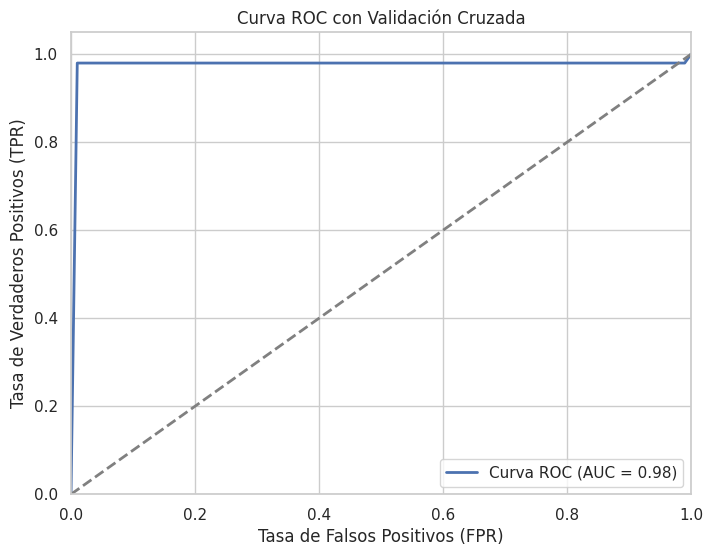

In [30]:
model_best = model #Cambie para colocar el parametro probability
cv = StratifiedKFold(n_splits=50, shuffle=True, random_state=42)
mean_fpr = np.linspace(0, 1, 100)
tprs = []

for train_index, test_index in cv.split(new_X, oversample_y):
    X_train, X_test = new_X[train_index], new_X[test_index]
    y_train, y_test = oversample_y[train_index], oversample_y[test_index]
    model_best.fit(X_train, y_train)
    y_pred_prob = model_best.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)

mean_tpr = np.mean(tprs, axis=0)
roc_auc = auc(mean_fpr, mean_tpr)

plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, color='b', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC con Validación Cruzada')
plt.legend(loc='lower right')
plt.savefig('ROCCurve_LogisticRegression.png', dpi=300, bbox_inches='tight')
plt.show()